# Zak Phase calculation for graphene nanoribbons

Let's make graphene and try to compute the Zak phase for different cell size and shape

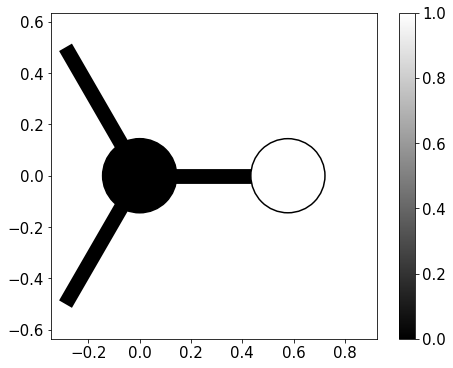

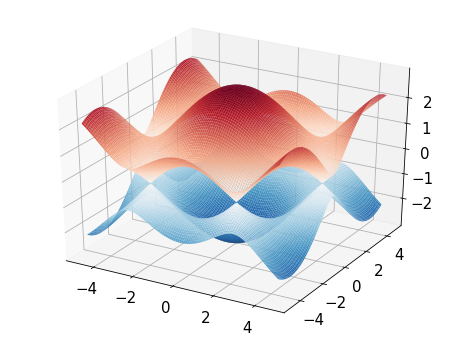

In [1]:
%run matplotlib_setup.ipy

from types import SimpleNamespace

from ipywidgets import interact
import matplotlib
from matplotlib import pyplot
from mpl_toolkits import mplot3d
import numpy as np
import scipy.linalg as la 

import kwant
from kwant.wraparound import wraparound, plot_2d_bands


def momentum_to_lattice(k):
    """Transform momentum to the basis of reciprocal lattice vectors.
    
    See https://en.wikipedia.org/wiki/Reciprocal_lattice#Generalization_of_a_dual_lattice
    """
    B = np.array(graphene.prim_vecs).T
    A = B.dot(np.linalg.inv(B.T.dot(B)))
    return np.linalg.solve(A, k)


def dispersion_2D(syst, args=None, lim=1.5*np.pi, num_points=200):
    """A simple plot of 2D band structure."""
    if args is None:
        args = []
    momenta = np.linspace(-lim, lim, num_points)
    energies = []
    for kx in momenta:
        for ky in momenta:
            lattice_k = momentum_to_lattice([kx, ky])
            h = syst.hamiltonian_submatrix(args=(list(args) + list(lattice_k)))
            energies.append(np.linalg.eigvalsh(h))
    
    energies = np.array(energies).reshape(num_points, num_points, -1)
    emin, emax = np.min(energies), np.max(energies)
    kx, ky = np.meshgrid(momenta, momenta)
    fig = pyplot.figure()
    axes = fig.add_subplot(1, 1, 1, projection='3d')
    for band in range(energies.shape[-1]):
        axes.plot_surface(kx, ky, energies[:, :, band], cstride=2, rstride=2,
                          cmap=matplotlib.cm.RdBu_r, vmin=emin, vmax=emax,
                          linewidth=0.1)
        
#Some helper functions to make the schematic look neat
def family_color(site): 
    if site.family == a: 
        return 0 
    else: 
        return 1
    
def hopping_lw(site1,site2): 
    return 0.1 if A in [site1.family,site2.family] else 0.05

graphene = kwant.lattice.general([[np.sqrt(3)/2,1/2],[np.sqrt(3)/2,-1/2]],  #Lattice vectors 
                                  [[0,0],[1/np.sqrt(3),0]]) # Co-ordinates
a,b = graphene.sublattices

bulk_graphene = kwant.Builder(kwant.TranslationalSymmetry(*graphene.prim_vecs))
bulk_graphene[graphene.shape((lambda pos: True), (0, 0))] = 0
bulk_graphene[graphene.neighbors(1)] = 1
kwant.plot(bulk_graphene,site_color=family_color,site_lw=0.01)
dispersion_2D(wraparound(bulk_graphene).finalized())

In [2]:
Zigzag = kwant.lattice.general([[1,0],[0,np.sqrt(3)/3]], #Lattice vectors
                                     [[1/6,0],[2/6,np.sqrt(3)/2],[4/6,np.sqrt(3)/2],[5/6,0]]) # Coordinates

def get_width(N=7): 
    if N < 2: 
        raise("N cannot be less than 2")
    else:
        return N/2*Zigzag.prim_vecs[1][1]

def make_1D_zigzag(N=7):
    syst = kwant.Builder(kwant.TranslationalSymmetry(Zigzag.prim_vecs[0]))
    syst[Zigzag.shape((lambda pos: pos[1] >0 and pos[1] <= get_width(N)),(0,0))] = 0
    syst[Zigzag.neighbors()] = -1
    return syst

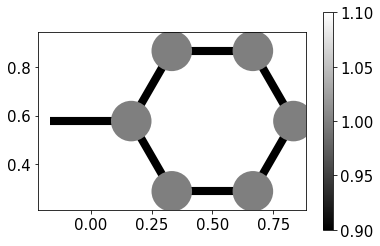

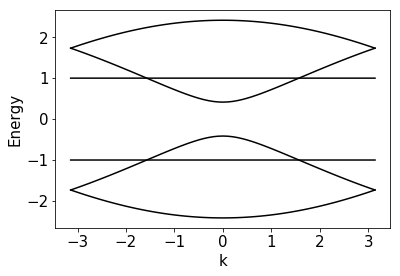


+----------------------------------------------------------------------+
|       ================                                               |
|       LINE CALCULATION                                               |
|       ================                                               |
|       starting at 2019-02-01 00:50:00,702                            |
|       running Z2Pack version 2.1.1                                   |
|                                                                      |
|       init_result: None                                              |
|       iterator:    range(200, 500, 2)                                |
|       line:        <function <lambda> at 0x7f5c427b07b8>             |
|       load:        False                                             |
|       load_quiet:  True                                              |
|       pos_tol:     0.001                                             |
|       save_file:   None                         


+----------------------------------------------------------------------+
|                   Calculation finished in 0h 0m 0s                   |
+----------------------------------------------------------------------+
+----------------------------------------------------------------------+
|                          ==================                          |
|                          CONVERGENCE REPORT                          |
|                          ==================                          |
|                                                                      |
|                          PosCheck: PASSED                            |
+----------------------------------------------------------------------+


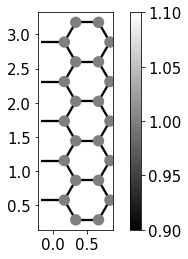

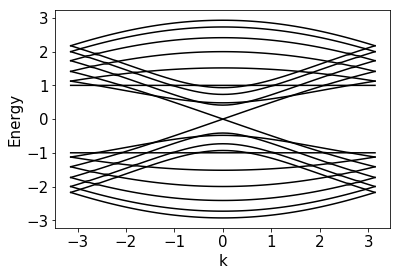


+----------------------------------------------------------------------+
|       ================                                               |
|       LINE CALCULATION                                               |
|       ================                                               |
|       starting at 2019-02-01 00:50:02,398                            |
|       running Z2Pack version 2.1.1                                   |
|                                                                      |
|       init_result: None                                              |
|       iterator:    range(200, 500, 2)                                |
|       line:        <function <lambda> at 0x7f5c13ca92f0>             |
|       load:        False                                             |
|       load_quiet:  True                                              |
|       pos_tol:     0.001                                             |
|       save_file:   None                         


+----------------------------------------------------------------------+
|                   Calculation finished in 0h 0m 0s                   |
+----------------------------------------------------------------------+
+----------------------------------------------------------------------+
|                          ==================                          |
|                          CONVERGENCE REPORT                          |
|                          ==================                          |
|                                                                      |
|                          PosCheck: PASSED                            |
+----------------------------------------------------------------------+

+----------------------------------------------------------------------+
|       ================                                               |
|       LINE CALCULATION                                               |
|       ================                         

INFO: 0 of 1 line convergence criteria fulfilled.
INFO:       Calculating line for N = 200
INFO: 0 of 1 line convergence criteria fulfilled.
INFO:       Calculating line for N = 202
INFO: 1 of 1 line convergence criteria fulfilled.

+----------------------------------------------------------------------+
|                   Calculation finished in 0h 0m 1s                   |
+----------------------------------------------------------------------+
+----------------------------------------------------------------------+
|                          ==================                          |
|                          CONVERGENCE REPORT                          |
|                          ==================                          |
|                                                                      |
|                          PosCheck: PASSED                            |
+----------------------------------------------------------------------+

+-----------------------------------

INFO: 0 of 1 line convergence criteria fulfilled.
INFO:       Calculating line for N = 200
INFO: 0 of 1 line convergence criteria fulfilled.
INFO:       Calculating line for N = 202
INFO: 1 of 1 line convergence criteria fulfilled.

+----------------------------------------------------------------------+
|                   Calculation finished in 0h 0m 0s                   |
+----------------------------------------------------------------------+
+----------------------------------------------------------------------+
|                          ==================                          |
|                          CONVERGENCE REPORT                          |
|                          ==================                          |
|                                                                      |
|                          PosCheck: PASSED                            |
+----------------------------------------------------------------------+


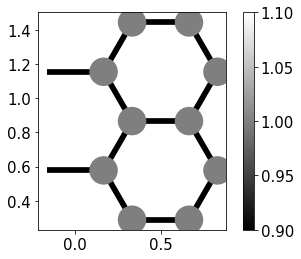

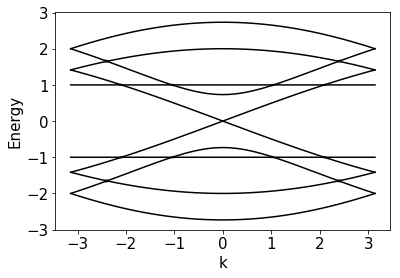


+----------------------------------------------------------------------+
|       ================                                               |
|       LINE CALCULATION                                               |
|       ================                                               |
|       starting at 2019-02-01 00:50:07,930                            |
|       running Z2Pack version 2.1.1                                   |
|                                                                      |
|       init_result: None                                              |
|       iterator:    range(200, 500, 2)                                |
|       line:        <function <lambda> at 0x7f5c427b07b8>             |
|       load:        False                                             |
|       load_quiet:  True                                              |
|       pos_tol:     0.001                                             |
|       save_file:   None                         


+----------------------------------------------------------------------+
|                   Calculation finished in 0h 0m 0s                   |
+----------------------------------------------------------------------+
+----------------------------------------------------------------------+
|                          ==================                          |
|                          CONVERGENCE REPORT                          |
|                          ==================                          |
|                                                                      |
|                          PosCheck: PASSED                            |
+----------------------------------------------------------------------+

+----------------------------------------------------------------------+
|       ================                                               |
|       LINE CALCULATION                                               |
|       ================                         

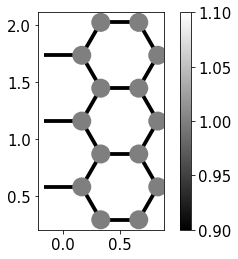

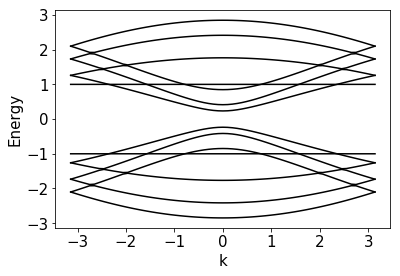


+----------------------------------------------------------------------+
|       ================                                               |
|       LINE CALCULATION                                               |
|       ================                                               |
|       starting at 2019-02-01 00:50:10,077                            |
|       running Z2Pack version 2.1.1                                   |
|                                                                      |
|       init_result: None                                              |
|       iterator:    range(200, 500, 2)                                |
|       line:        <function <lambda> at 0x7f5c132e5ae8>             |
|       load:        False                                             |
|       load_quiet:  True                                              |
|       pos_tol:     0.001                                             |
|       save_file:   None                         


+----------------------------------------------------------------------+
|                   Calculation finished in 0h 0m 0s                   |
+----------------------------------------------------------------------+
+----------------------------------------------------------------------+
|                          ==================                          |
|                          CONVERGENCE REPORT                          |
|                          ==================                          |
|                                                                      |
|                          PosCheck: PASSED                            |
+----------------------------------------------------------------------+

+----------------------------------------------------------------------+
|       ================                                               |
|       LINE CALCULATION                                               |
|       ================                         

INFO: 0 of 1 line convergence criteria fulfilled.
INFO:       Calculating line for N = 200
INFO: 0 of 1 line convergence criteria fulfilled.
INFO:       Calculating line for N = 202
INFO: 1 of 1 line convergence criteria fulfilled.

+----------------------------------------------------------------------+
|                   Calculation finished in 0h 0m 0s                   |
+----------------------------------------------------------------------+
+----------------------------------------------------------------------+
|                          ==================                          |
|                          CONVERGENCE REPORT                          |
|                          ==================                          |
|                                                                      |
|                          PosCheck: PASSED                            |
+----------------------------------------------------------------------+


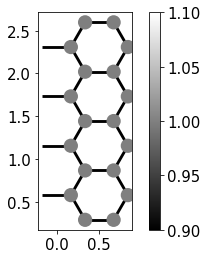

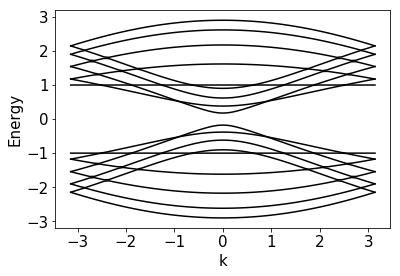


+----------------------------------------------------------------------+
|       ================                                               |
|       LINE CALCULATION                                               |
|       ================                                               |
|       starting at 2019-02-01 00:50:13,131                            |
|       running Z2Pack version 2.1.1                                   |
|                                                                      |
|       init_result: None                                              |
|       iterator:    range(200, 500, 2)                                |
|       line:        <function <lambda> at 0x7f5c132e5c80>             |
|       load:        False                                             |
|       load_quiet:  True                                              |
|       pos_tol:     0.001                                             |
|       save_file:   None                         


+----------------------------------------------------------------------+
|                   Calculation finished in 0h 0m 0s                   |
+----------------------------------------------------------------------+
+----------------------------------------------------------------------+
|                          ==================                          |
|                          CONVERGENCE REPORT                          |
|                          ==================                          |
|                                                                      |
|                          PosCheck: PASSED                            |
+----------------------------------------------------------------------+

+----------------------------------------------------------------------+
|       ================                                               |
|       LINE CALCULATION                                               |
|       ================                         

INFO: 0 of 1 line convergence criteria fulfilled.
INFO:       Calculating line for N = 200
INFO: 0 of 1 line convergence criteria fulfilled.
INFO:       Calculating line for N = 202
INFO: 1 of 1 line convergence criteria fulfilled.

+----------------------------------------------------------------------+
|                   Calculation finished in 0h 0m 0s                   |
+----------------------------------------------------------------------+
+----------------------------------------------------------------------+
|                          ==================                          |
|                          CONVERGENCE REPORT                          |
|                          ==================                          |
|                                                                      |
|                          PosCheck: PASSED                            |
+----------------------------------------------------------------------+

+-----------------------------------

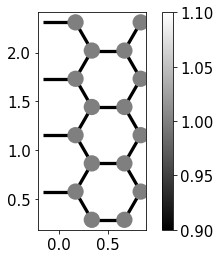

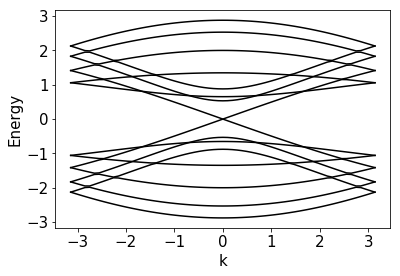


+----------------------------------------------------------------------+
|       ================                                               |
|       LINE CALCULATION                                               |
|       ================                                               |
|       starting at 2019-02-01 00:50:17,479                            |
|       running Z2Pack version 2.1.1                                   |
|                                                                      |
|       init_result: None                                              |
|       iterator:    range(200, 500, 2)                                |
|       line:        <function <lambda> at 0x7f5c132e5ae8>             |
|       load:        False                                             |
|       load_quiet:  True                                              |
|       pos_tol:     0.001                                             |
|       save_file:   None                         


+----------------------------------------------------------------------+
|                   Calculation finished in 0h 0m 0s                   |
+----------------------------------------------------------------------+
+----------------------------------------------------------------------+
|                          ==================                          |
|                          CONVERGENCE REPORT                          |
|                          ==================                          |
|                                                                      |
|                          PosCheck: PASSED                            |
+----------------------------------------------------------------------+

+----------------------------------------------------------------------+
|       ================                                               |
|       LINE CALCULATION                                               |
|       ================                         

INFO: 0 of 1 line convergence criteria fulfilled.
INFO:       Calculating line for N = 200
INFO: 0 of 1 line convergence criteria fulfilled.
INFO:       Calculating line for N = 202
INFO: 1 of 1 line convergence criteria fulfilled.

+----------------------------------------------------------------------+
|                   Calculation finished in 0h 0m 0s                   |
+----------------------------------------------------------------------+
+----------------------------------------------------------------------+
|                          ==================                          |
|                          CONVERGENCE REPORT                          |
|                          ==================                          |
|                                                                      |
|                          PosCheck: PASSED                            |
+----------------------------------------------------------------------+

+-----------------------------------

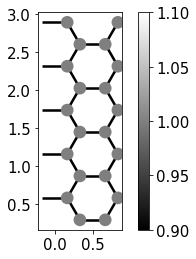

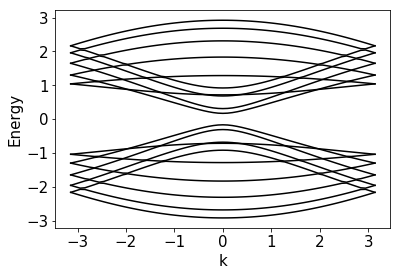


+----------------------------------------------------------------------+
|       ================                                               |
|       LINE CALCULATION                                               |
|       ================                                               |
|       starting at 2019-02-01 00:50:20,527                            |
|       running Z2Pack version 2.1.1                                   |
|                                                                      |
|       init_result: None                                              |
|       iterator:    range(200, 500, 2)                                |
|       line:        <function <lambda> at 0x7f5c132e5c80>             |
|       load:        False                                             |
|       load_quiet:  True                                              |
|       pos_tol:     0.001                                             |
|       save_file:   None                         


+----------------------------------------------------------------------+
|                   Calculation finished in 0h 0m 0s                   |
+----------------------------------------------------------------------+
+----------------------------------------------------------------------+
|                          ==================                          |
|                          CONVERGENCE REPORT                          |
|                          ==================                          |
|                                                                      |
|                          PosCheck: PASSED                            |
+----------------------------------------------------------------------+

+----------------------------------------------------------------------+
|       ================                                               |
|       LINE CALCULATION                                               |
|       ================                         

INFO: 0 of 1 line convergence criteria fulfilled.
INFO:       Calculating line for N = 200
INFO: 0 of 1 line convergence criteria fulfilled.
INFO:       Calculating line for N = 202
INFO: 1 of 1 line convergence criteria fulfilled.

+----------------------------------------------------------------------+
|                   Calculation finished in 0h 0m 0s                   |
+----------------------------------------------------------------------+
+----------------------------------------------------------------------+
|                          ==================                          |
|                          CONVERGENCE REPORT                          |
|                          ==================                          |
|                                                                      |
|                          PosCheck: PASSED                            |
+----------------------------------------------------------------------+

+-----------------------------------

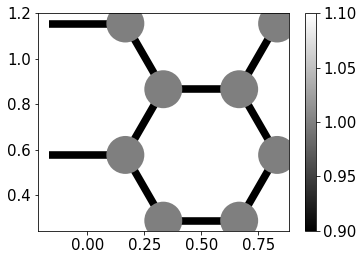

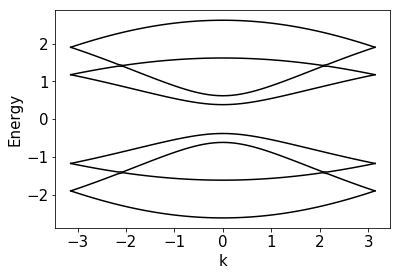


+----------------------------------------------------------------------+
|       ================                                               |
|       LINE CALCULATION                                               |
|       ================                                               |
|       starting at 2019-02-01 00:50:25,329                            |
|       running Z2Pack version 2.1.1                                   |
|                                                                      |
|       init_result: None                                              |
|       iterator:    range(200, 500, 2)                                |
|       line:        <function <lambda> at 0x7f5c13dac620>             |
|       load:        False                                             |
|       load_quiet:  True                                              |
|       pos_tol:     0.001                                             |
|       save_file:   None                         


+----------------------------------------------------------------------+
|                   Calculation finished in 0h 0m 0s                   |
+----------------------------------------------------------------------+
+----------------------------------------------------------------------+
|                          ==================                          |
|                          CONVERGENCE REPORT                          |
|                          ==================                          |
|                                                                      |
|                          PosCheck: PASSED                            |
+----------------------------------------------------------------------+

+----------------------------------------------------------------------+
|       ================                                               |
|       LINE CALCULATION                                               |
|       ================                         

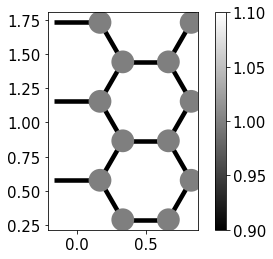

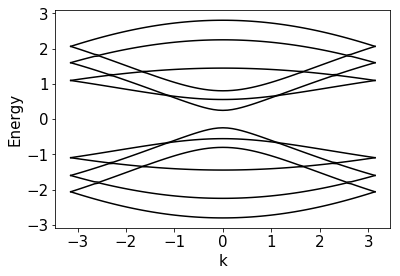


+----------------------------------------------------------------------+
|       ================                                               |
|       LINE CALCULATION                                               |
|       ================                                               |
|       starting at 2019-02-01 00:50:26,769                            |
|       running Z2Pack version 2.1.1                                   |
|                                                                      |
|       init_result: None                                              |
|       iterator:    range(200, 500, 2)                                |
|       line:        <function <lambda> at 0x7f5c1322ce18>             |
|       load:        False                                             |
|       load_quiet:  True                                              |
|       pos_tol:     0.001                                             |
|       save_file:   None                         


+----------------------------------------------------------------------+
|                   Calculation finished in 0h 0m 0s                   |
+----------------------------------------------------------------------+
+----------------------------------------------------------------------+
|                          ==================                          |
|                          CONVERGENCE REPORT                          |
|                          ==================                          |
|                                                                      |
|                          PosCheck: PASSED                            |
+----------------------------------------------------------------------+

+----------------------------------------------------------------------+
|       ================                                               |
|       LINE CALCULATION                                               |
|       ================                         

In [19]:
N_list =[3,11,5,7,9,8,10,4,6]
pol_N={}
import z2pack
from Z2_compute import zak_bands as zak_bands_z2
for N in N_list:
    # Making a Zigzag lead
    Zigzag_1d = make_1D_zigzag(N=N) 
    kwant.plot(Zigzag_1d,site_color=family_color);
    Zigzag_1d = Zigzag_1d.finalized()
    kwant.plotter.bands(Zigzag_1d);

    act_pos = np.array([Zigzag_1d.pos(i) for i in range(2*N)])
    a1,a2 = [Zigzag.prim_vecs[0][0],get_width(N=N)]
    red_pos = np.zeros(np.shape(act_pos))
    red_pos[:,0] = act_pos[:,0]/a1
    red_pos[:,1] = act_pos[:,1]/a2


    ham_k=zak_bands_z2(Zigzag_1d,momenta=1001,dim=1)
    z2_system = z2pack.hm.System(ham_k,dim=1,pos=red_pos,
                                 convention=2)
    pol_sum = 0
    for n in range(0,N+1):
        result1 = z2pack.line.run(system=z2_system, 
                                 line=lambda t1: [t1,n/(N+1)],
                                 pos_tol=1e-3,iterator=range(200,500,2));
    #np.exp(-1*2*np.pi*np.sum(np.log(np.diagonal(result.wilson))))
    #result.pol
        #result12 = z2pack.line.run(system=z2_system, 
        #                         line=lambda t1: [t1,-n/(N+1)],
        #                         pos_tol=1e-2)
        pol_sum += result1.pol
        #pol_sum += result2.pol
        
    
    pol_N[N] = pol_sum % 1

In [20]:
pol_N

{3: 2.6645352591003757e-15,
 11: 0.8729395199758674,
 5: 0.4975124378109541,
 7: 2.6645352591003757e-15,
 9: 7.105427357601002e-15,
 8: 0.7462686567164205,
 10: 0.9999999999999947,
 4: 0.4999999999999911,
 6: 0.5000000000000209}

    # Zigzag'

In [ ]:
Zigzag_dash = kwant.lattice.general([[1,0],[0,np.sqrt(3)/3]], #Lattice vectors
                                     [[1/6,0],[2/6,-np.sqrt(3)/2],[4/6,-np.sqrt(3)/2],[5/6,0]]) # Coordinates

def get_width_dash(N=7): 
    #if N < 2: 
        #raise("N cannot be less than 2")
    #else:
    return N/2*Zigzag_dash.prim_vecs[1][1]

def make_1D_zigzag_dash(N=7):
    syst = kwant.Builder(kwant.TranslationalSymmetry(Zigzag_dash.prim_vecs[0]))
    syst[Zigzag_dash.shape((lambda pos: pos[1] >-1*get_width_dash(1) and pos[1] <= get_width_dash(N-1)),(0,0))] = 0
    syst[Zigzag_dash.neighbors()] = -1
    return syst

In [ ]:
N_list =[3,11,5,7,9,8,10,4,6]
pol_N={}
for N in N_list:
    # Making a Zigzag lead
    Zigzag_1d = make_1D_zigzag_dash(N=N) 
    kwant.plot(Zigzag_1d,site_color=family_color);
    Zigzag_1d = Zigzag_1d.finalized()
    kwant.plotter.bands(Zigzag_1d);

    act_pos = np.array([Zigzag_1d.pos(i) for i in range(2*N)])
    a1,a2 = [Zigzag.prim_vecs[0][0],get_width_dash(N=N)]
    red_pos = np.zeros(np.shape(act_pos))
    red_pos[:,0] = act_pos[:,0]/a1
    red_pos[:,1] = act_pos[:,1]/a2

    import z2pack
    from Z2_compute import zak_bands as zak_bands_z2
    ham_k=zak_bands_z2(Zigzag_1d,momenta=1001,dim=1)
    z2_system = z2pack.hm.System(ham_k,dim=1,pos=red_pos,convention=1)
    pol_sum = 0
    #for n in range(0,N+1):
    result = z2pack.surface.run(system=z2_system, surface=lambda t1,t2: [t1,t2],num_lines=2*N+1);
    #np.exp(-1*2*np.pi*np.sum(np.log(np.diagonal(result.wilson))))
    #result.pol
        #pol_sum += result.pol
    
    pol_N[N] = z2pack.invariant.chern(result)

In [ ]:
pol_N

In [ ]:
from Zak_compute import zak_bands
[tempm,wf]=zak_bands(Zigzag_1d.finalized(),momenta=101)

## Z2 pack code

In [ ]:
act_pos = np.array([Zigzag_1d.pos(i) for i in range(2*N)])
a1,a2 = [Zigzag.prim_vecs[0][0],get_width(N=N)]
red_pos = np.zeros(np.shape(act_pos))
red_pos[:,0] = act_pos[:,0]/a1
red_pos[:,1] = act_pos[:,1]/a2

In [ ]:
red_pos

In [ ]:
import z2pack
from Z2_compute import zak_bands as zak_bands_z2
ham_k=zak_bands_z2(Zigzag_1d,momenta=1001,dim=1)
z2_system = z2pack.hm.System(ham_k,dim=1,pos=red_pos)
pol_sum = 0
for n in range(0,N+1):
    result = z2pack.line.run(system=z2_system, line=lambda t1: [t1,n/(N+1)]);
#np.exp(-1*2*np.pi*np.sum(np.log(np.diagonal(result.wilson))))
#result.pol
    pol_sum += result.pol


In [ ]:
result.wcc

In [ ]:
from Zak_compute import zak_bands
[tempm,wf]=zak_bands(Zigzag_1d.finalized(),momenta=101)

In [ ]:
result

In [ ]:
sum(result.wcc)

In [ ]:
-1j*np.imag(np.sum(np.log(result.wilson)))/2*np.pi

In [ ]:
for i in range(0,N+1):
    result = z2pack.line.run(system=z2_system, line=lambda t1: [t1*2-1,i/(N+1)*2-1,0]);
    result.gap_pos
    result.pol
    z2_sum += z2pack.invariant.z2(result)
print(z2_sum)

In [ ]:
z2_system.get_eig

In [ ]:
num_kpoints = np.shape(wf)[0]
num_bands = np.shape(wf)[1] 
num_basis = np.shape(wf)[2] 
dk = np.linspace(-np.pi,np.pi,num_kpoints)[0]
gamma_n = [] 
for n in range(num_bands):
    gamma = 1
    for k0 in range(num_kpoints-1):
        if k0+1 == num_kpoints: 
            k1=0
        else:
            k1 = k0 + 1 
        u_nk0 = wf[k0][n,:]
        u_nk1 = wf[k1][n,:]
        bra_unk = np.transpose(np.conj(u_nk0))
        #bra_unk = np.matrix.getH(u_nk0)
        gamma = gamma*np.inner(bra_unk,u_nk1)
    gamma_n.append(gamma)
np.exp(-1j*np.imag(np.sum(np.log(gamma_n)))) 

In [ ]:
np.imag(np.sum(np.log(gamma_n)))

In [ ]:
np.imag(np.sum(np.log(np.diagonal(result.wilson))))

In [ ]:
ham_k([1,0,0])